# ModernBERT with unbalanced dataset
Notebook by: [Juliana Gómez Consuegra](https://www.linkedin.com/in/julianagomezconsuegra/)

- Documentation: https://huggingface.co/docs/transformers/en/model_doc/modernbert

Notes:

- The pre-trained ModernBERT-base model doesn't include a classification layer, so when you create a ModernBertForSequenceClassification model, it adds a new classification layer on top of the base model.


In [1]:
#upgrade fsspec to solve dependency issuse
!pip install -U fsspec==2024.10.0

!pip install -q datasets
!pip install -q codecarbon
!pip install -q -U transformers>=4.48.0


  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.10.0-py3-none-any.whl (179 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.2.0 requires fsspec[http]<=2024.9.0,>=2023.1.0, but you have fsspec 2024.10.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127

In [2]:
from google.colab import drive

#standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime


#emissions tracking
from codecarbon import EmissionsTracker


# accuracy and model
from datasets import Dataset, load_dataset, DatasetDict
import torch
from functools import partial
import gc
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from transformers import AutoTokenizer, ModernBertForSequenceClassification,TrainingArguments, Trainer, TrainerCallback, DataCollatorWithPadding

#sound at end of training
from google.colab import output


In [3]:
# # dataset
# dataset = load_dataset("quotaclimat/frugalaichallenge-text-train")

# # Define the label mapping
# LABEL_MAPPING = {
#     "0_not_relevant": 0,
#     "1_not_happening": 1,
#     "2_not_human": 2,
#     "3_not_bad": 3,
#     "4_solutions_harmful_unnecessary": 4,
#     "5_science_unreliable": 5,
#     "6_proponents_biased": 6,
#     "7_fossil_fuels_needed": 7
# }

# # Convert string labels to integers
# dataset = dataset.map(lambda x: {"label": LABEL_MAPPING[x["label"]]})

In [4]:
# file_path = '/content/drive/MyDrive/frugal_ai'
drive.mount('/content/drive')


X_train = pd.read_csv('/content/drive/MyDrive/frugal_ai/Juliana/X_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/frugal_ai/Juliana/X_test.csv')
y_train = pd.read_csv('/content/drive/MyDrive/frugal_ai/Juliana/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/frugal_ai/Juliana/y_test.csv')

#split test into val and test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_dataset = Dataset.from_pandas(pd.concat([X_train, y_train], axis=1))
val_dataset = Dataset.from_pandas(pd.concat([X_val, y_val], axis=1))
test_dataset = Dataset.from_pandas(pd.concat([X_test, y_test], axis=1))

In [6]:
dataset = DatasetDict({
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
})

In [7]:
# Define the label mapping
LABEL_MAPPING = {
    "0_not_relevant": 0,
    "1_not_happening": 1,
    "2_not_human": 2,
    "3_not_bad": 3,
    "4_solutions_harmful_unnecessary": 4,
    "5_science_unreliable": 5,
    "6_proponents_biased": 6,
    "7_fossil_fuels_needed": 7
}

def map_labels(example):
    example['label'] = LABEL_MAPPING[example['label']]
    return example

dataset = dataset.map(map_labels)

Map:   0%|          | 0/3599 [00:00<?, ? examples/s]

Map:   0%|          | 0/472 [00:00<?, ? examples/s]

Map:   0%|          | 0/473 [00:00<?, ? examples/s]

# Fine-tuning ModernBERT on the dataset

In [8]:
# Load tokenizer
model_name = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model with alternative attention implementation
model = ModernBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(LABEL_MAPPING),
    attn_implementation="sdpa"  #SDPA (Scaled Dot Product Attention)
).to('cuda')

model.gradient_checkpointing_enable()



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Freeze all layers except the last one
for name, param in model.named_parameters():
    if 'layers.' in name:
        layer_num = int(name.split('.')[2])
        if layer_num < 21:
            param.requires_grad = False

# Verify the freezing
for name, param in model.named_parameters():
    if 'layers.' in name:
        layer_num = int(name.split('.')[2])
        print(f"Layer {layer_num}: {param.requires_grad}")
    else:
        print(f"{name}: {param.requires_grad}")


model.embeddings.tok_embeddings.weight: True
model.embeddings.norm.weight: True
Layer 0: False
Layer 0: False
Layer 0: False
Layer 0: False
Layer 0: False
Layer 1: False
Layer 1: False
Layer 1: False
Layer 1: False
Layer 1: False
Layer 1: False
Layer 2: False
Layer 2: False
Layer 2: False
Layer 2: False
Layer 2: False
Layer 2: False
Layer 3: False
Layer 3: False
Layer 3: False
Layer 3: False
Layer 3: False
Layer 3: False
Layer 4: False
Layer 4: False
Layer 4: False
Layer 4: False
Layer 4: False
Layer 4: False
Layer 5: False
Layer 5: False
Layer 5: False
Layer 5: False
Layer 5: False
Layer 5: False
Layer 6: False
Layer 6: False
Layer 6: False
Layer 6: False
Layer 6: False
Layer 6: False
Layer 7: False
Layer 7: False
Layer 7: False
Layer 7: False
Layer 7: False
Layer 7: False
Layer 8: False
Layer 8: False
Layer 8: False
Layer 8: False
Layer 8: False
Layer 8: False
Layer 9: False
Layer 9: False
Layer 9: False
Layer 9: False
Layer 9: False
Layer 9: False
Layer 10: False
Layer 10: False
Lay

In [10]:
# see all layers
# for name, param in model.named_parameters():
#     print(name)

### Tokenize the dataset

In [11]:
def tokenize_function(examples):
  '''Adds CLS and SEP tokens for multiclass classification.'''
  return tokenizer(examples['quote'], padding="max_length", truncation=True,add_special_tokens=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/3599 [00:00<?, ? examples/s]

Map:   0%|          | 0/472 [00:00<?, ? examples/s]

Map:   0%|          | 0/473 [00:00<?, ? examples/s]

In [12]:
# see dataset dictionary
# tokenized_datasets

In [13]:
def show_tokens(dataset, index=0, split='train'):
    example = dataset[split][index]
    tokens = tokenizer.convert_ids_to_tokens(example['input_ids'])
    print(f"Tokens for example {index} in {split} set:")
    print(tokens)
    print("\nOriginal quote:")
    print(example['quote'])

# Usage
show_tokens(tokenized_datasets)


Tokens for example 0 in train set:
['[CLS]', 'I', ',', 'ĠI', 'âĢĻ', 'm', 'Ġnot', 'Ġsure', 'Ġwhy', ',', 'Ġuh', ',', 'Ġpeople', 'Ġhave', 'Ġtried', 'Ġto', 'Ġmake', 'Ġsomething', 'Ġof', 'Ġthat', '.', 'ĠBut', 'Ġpeople', 'Ġhave', 'Ġto', 'Ġhave', 'Ġjobs', '.', 'ĠAnd', 'Ġthat', 'âĢĻ', 's', 'Ġthe', 'Ġway', 'Ġit', 'Ġworks', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

### Set up hyperparameters

In [14]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


In [15]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    run_name="modernbert-classification-3-epochs-1-layer",
    num_train_epochs=3,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    gradient_accumulation_steps=4,
    fp16=True,
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
# set accuracy as metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

### Fine-tune

In [17]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


class MetricsLoggerCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                train_losses.append(logs["loss"])
            if "eval_loss" in logs:
                val_losses.append(logs["eval_loss"])
            if "eval_accuracy" in logs:
                val_accuracies.append(logs["eval_accuracy"])
            if "accuracy" in logs:
                train_accuracies.append(logs["accuracy"])


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[MetricsLoggerCallback],
)

trainer.train()

#produce a sound to signal end of training (Strawberry poison frog!)
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')


<ipython-input-17-468528513f3f>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[codecarbon INFO @ 16:10:29] [setup] RAM Tracking...
[codecarbon INFO @ 16:10:29] [setup] CPU Tracking...
[codecarbon WARNING @ 16:10:29] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 16:10:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:10:31] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 16:10:31] [setup] GPU Tracking...
[codecarbon INFO @ 16:10:31] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:10:31] >>> Tracker's metadata:
[codecarbon INFO @ 16:10:31]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 16:10:31] 

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


[codecarbon INFO @ 16:11:34] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 16:11:34] Energy consumed for all CPUs : 0.000178 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:11:34] Energy consumed for all GPUs : 0.000138 kWh. Total GPU Power : 33.04524332641625 W
[codecarbon INFO @ 16:11:34] 0.000335 kWh of electricity used since the beginning.


Step,Training Loss,Validation Loss,Accuracy
100,9.060500,2.159567,0.165254
200,8.508200,2.033476,0.156780
300,7.616200,1.866570,0.254237
400,6.536900,1.515378,0.476695
500,5.399200,1.225489,0.578390
600,4.818600,1.180707,0.574153
700,4.323200,1.096985,0.625000
800,4.895600,1.086906,0.614407
900,3.436300,0.991223,0.635593
1000,2.857900,1.014594,0.667373


Streaming output truncated to the last 5000 lines.
[codecarbon INFO @ 23:39:20] Energy consumed for RAM : 0.035440 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 23:39:20] Energy consumed for all CPUs : 0.317011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:20] Energy consumed for all GPUs : 0.461503 kWh. Total GPU Power : 64.63421183807363 W
[codecarbon INFO @ 23:39:20] 0.813953 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:39:35] Energy consumed for RAM : 0.035460 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 23:39:35] Energy consumed for all CPUs : 0.317188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:35] Energy consumed for all GPUs : 0.461774 kWh. Total GPU Power : 65.0522198129653 W
[codecarbon INFO @ 23:39:35] 0.814422 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:39:50] Energy consumed for RAM : 0.035480 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 23:39:50] Energy consumed for all CPU

Step,Training Loss,Validation Loss,Accuracy
100,9.060500,2.159567,0.165254
200,8.508200,2.033476,0.156780
300,7.616200,1.866570,0.254237
400,6.536900,1.515378,0.476695
500,5.399200,1.225489,0.578390
600,4.818600,1.180707,0.574153
700,4.323200,1.096985,0.625000
800,4.895600,1.086906,0.614407
900,3.436300,0.991223,0.635593
1000,2.857900,1.014594,0.667373


[codecarbon INFO @ 04:43:01] Energy consumed for RAM : 0.059462 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 04:43:01] Energy consumed for all CPUs : 0.531892 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:43:01] Energy consumed for all GPUs : 0.773101 kWh. Total GPU Power : 64.34693923805236 W
[codecarbon INFO @ 04:43:01] 1.364456 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:43:16] Energy consumed for RAM : 0.059482 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 04:43:16] Energy consumed for all CPUs : 0.532070 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 04:43:16] Energy consumed for all GPUs : 0.773369 kWh. Total GPU Power : 64.40539031689941 W
[codecarbon INFO @ 04:43:16] 1.364921 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:43:31] Energy consumed for RAM : 0.059502 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 04:43:31] Energy consumed for all CPUs : 0.532247 kWh. Total CPU Power : 42.5 W
[codeca

### Training curve

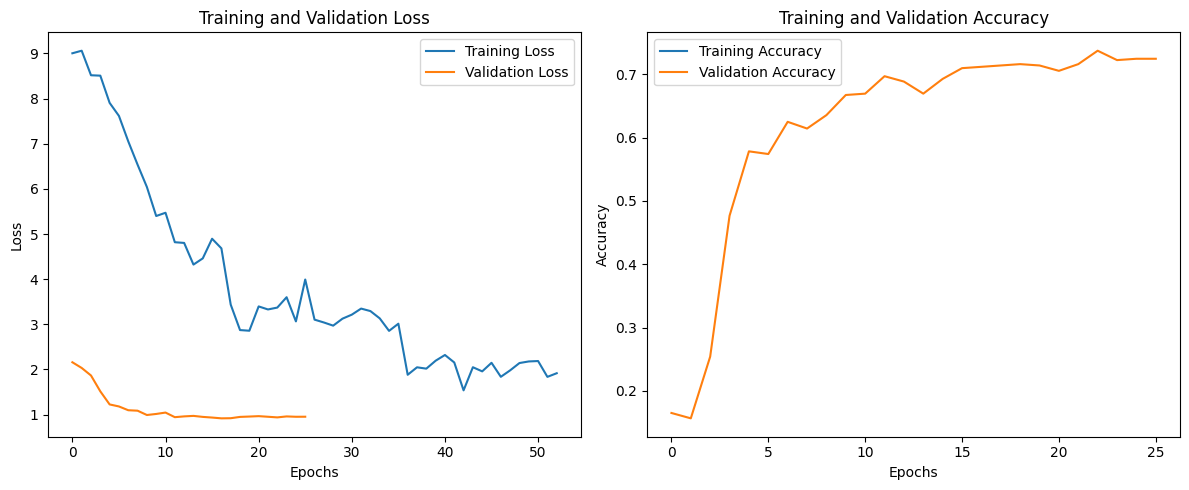

In [18]:
# Plotting after training
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Inference

In [19]:
# def evaluate_text(trainer, tokenized_datasets, dataset_name="quotaclimat/frugalaichallenge-text-train"):
#     # Initialize CodeCarbon tracker
#     tracker = EmissionsTracker(project_name="text_classification_baseline")

#     # Start tracking emissions
#     tracker.start()

#     ########################################################################
#     # ModernBERT inference
#     test_results = trainer.evaluate(tokenized_datasets["test"])
#     print(f"Test results: {test_results}")
#     ########################################################################

#     # Stop tracking emissions
#     emissions = tracker.stop()

#     # Prepare results dictionary
#     results = {
#         "accuracy": float(test_results["eval_accuracy"]),
#         "energy_consumed_wh": emissions.energy_consumed * 1000,
#         "emissions_gco2eq": emissions.emissions * 1000,
#         "emissions_data": emissions,
#         "dataset_config": {
#             "dataset_name": dataset_name,
#             "test_size": len(tokenized_datasets["test"]),
#         }
#     }

#     return results


In [20]:
# evaluation_results = evaluate_text(trainer, tokenized_datasets)
# print(evaluation_results)


# Save the model and tokenizer

In [21]:
# # After training is complete
trainer.save_model("./results")
tokenizer.save_pretrained("./results")

('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/tokenizer.json')

# For the submission

This is how to change the .py file:

In [22]:
# from fastapi import APIRouter
# from datetime import datetime
# from datasets import load_dataset
# from sklearn.metrics import accuracy_score
# from transformers import AutoModelForSequenceClassification, AutoTokenizer
# import torch

# from .utils.evaluation import TextEvaluationRequest
# from .utils.emissions import tracker, clean_emissions_data, get_space_info

# router = APIRouter()

# DESCRIPTION = "Fine-tuned ModernBERT for Climate Disinformation Detection"
# ROUTE = "/text"

# @router.post(ROUTE, tags=["Text Task"],
#              description=DESCRIPTION)
# async def evaluate_text(request: TextEvaluationRequest):
#     # Get space info
#     username, space_url = get_space_info()

#     # Define the label mapping
#     LABEL_MAPPING = {
#         "0_not_relevant": 0,
#         "1_not_happening": 1,
#         "2_not_human": 2,
#         "3_not_bad": 3,
#         "4_solutions_harmful_unnecessary": 4,
#         "5_science_unreliable": 5,
#         "6_proponents_biased": 6,
#         "7_fossil_fuels_needed": 7
#     }

#     # Load the dataset
#     dataset = load_dataset(request.dataset_name)

#     # Start tracking emissions
#     tracker.start()
#     tracker.start_task("model_loading_and_inference")

#     #--------------------------------------------------------------------------------------------
#     # MODEL LOADING AND INFERENCE CODE

#     # Load the fine-tuned model and tokenizer
#     model_path = "path/to/your/saved/model"  # Replace with your model path or HuggingFace model ID
#     model = AutoModelForSequenceClassification.from_pretrained(model_path)
#     tokenizer = AutoTokenizer.from_pretrained(model_path)

#     # Move model to GPU if available (T4 in this case)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)

#     # Optimize model for inference
#     model.eval()

#     # Function to perform inference on a batch of texts
#     def predict_batch(texts):
#         inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
#         with torch.no_grad():
#             outputs = model(**inputs)
#         return torch.argmax(outputs.logits, dim=1).cpu().numpy()

#     # Perform inference on the entire dataset
#     batch_size = 32  # Adjust based on T4 memory constraints
#     all_predictions = []

#     for i in range(0, len(dataset['train']), batch_size):
#         batch_texts = dataset['train'][i:i+batch_size]['text']
#         batch_predictions = predict_batch(batch_texts)
#         all_predictions.extend(batch_predictions)

#     #--------------------------------------------------------------------------------------------
#     # MODEL INFERENCE ENDS HERE

#     # Stop tracking emissions
#     emissions_data = tracker.stop_task()

#     # Prepare results dictionary (without calculating accuracy)
#     results = {
#         "username": username,
#         "space_url": space_url,
#         "submission_timestamp": datetime.now().isoformat(),
#         "model_description": DESCRIPTION,
#         "energy_consumed_wh": emissions_data.energy_consumed * 1000,
#         "emissions_gco2eq": emissions_data.emissions * 1000,
#         "emissions_data": clean_emissions_data(emissions_data),
#         "api_route": ROUTE,
#         "dataset_config": {
#             "dataset_name": request.dataset_name
#         }
#     }

#     return results
